In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv("../data/bike_buyers_limpio.csv")

In [22]:
data.drop('Unnamed: 0', inplace = True, axis = 1)
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Female,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


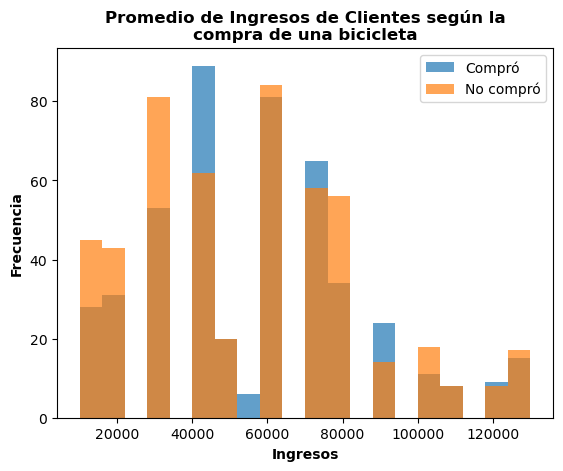

In [23]:
MS_prom = data.groupby('Purchased Bike')['Income']
bins = 20
alpha = 0.7

plt.hist(MS_prom.get_group('Yes'), bins=bins, alpha=alpha, label='Compró')
plt.hist(MS_prom.get_group('No'), bins=bins, alpha=alpha, label='No compró')

plt.title('Promedio de Ingresos de Clientes según la\ncompra de una bicicleta', weight='bold')
plt.xlabel('Ingresos', weight='bold')
plt.ylabel('Frecuencia', weight='bold')
plt.legend()
plt.show()

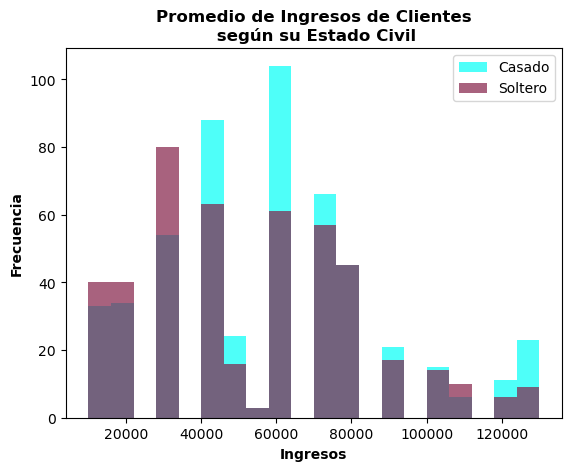

In [27]:
MS_prom = data.groupby(['Marital Status'])['Income']

plt.hist(MS_prom.get_group('Married'), bins=bins, alpha=alpha, label='Casado', color='#03FFF7')
plt.hist(MS_prom.get_group('Single'), bins=bins, alpha=alpha, label='Soltero', color='#842048')

plt.title('Promedio de Ingresos de Clientes\n según su Estado Civil', weight = 'bold')
plt.xlabel('Ingresos', weight='bold')
plt.ylabel('Frecuencia', weight='bold')
plt.legend()
plt.show()

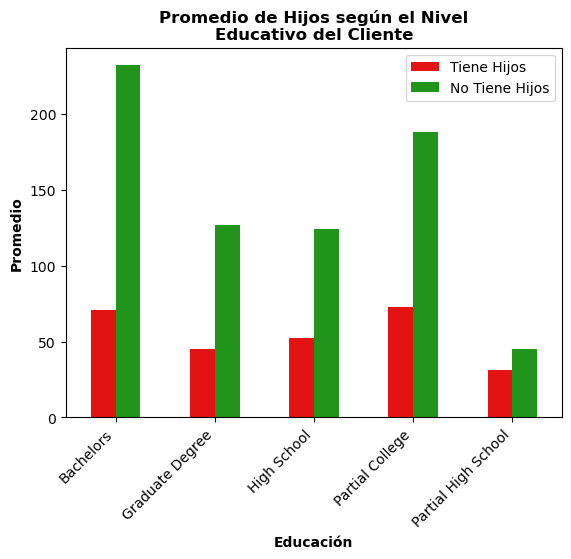

In [133]:
data['Con_hijos'] = np.where(data['Children'] != 0.0, 'Si', 'No')
Hijos_prom = data[['Education', 'Con_hijos']]
HP = Hijos_prom.groupby(['Education', 'Con_hijos']).size()
df = pd.DataFrame({'Frecuencia': HP.values}, index = HP.index)

df_pivot = df.pivot_table(index = 'Education', columns = 'Con_hijos', values = 'Frecuencia')
colores = ['#E41313', '#20941B']
ax = df_pivot.plot(kind = 'bar', stacked = False, color = colores)

ax.set_xlabel('Educación', weight = 'bold')
ax.set_ylabel('Promedio', weight = 'bold')
ax.set_title('Promedio de Hijos según el Nivel\nEducativo del Cliente', weight = 'bold')

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.legend(['Tiene Hijos', 'No Tiene Hijos'])

plt.show()

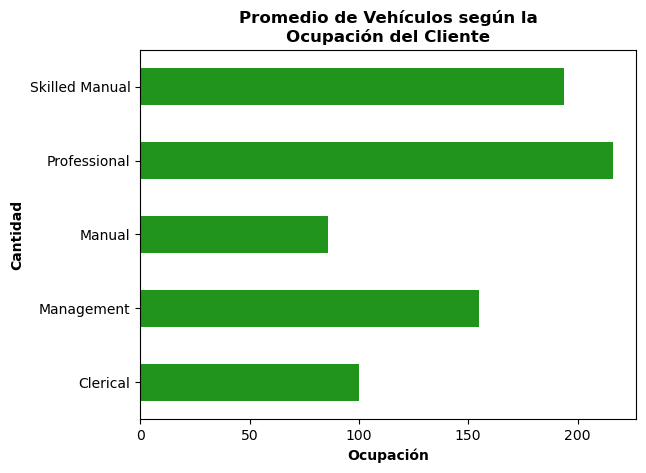

In [134]:
data['Con_vehiculo'] = np.where(data['Cars'] != 0.0, 'Si', 'No')
V_Si = data[data['Con_vehiculo'] == 'Si']
Vehiculo_prom = V_Si[['Occupation', 'Con_vehiculo']]
VP = Vehiculo_prom.groupby(['Occupation', 'Con_vehiculo']).size()
df = pd.DataFrame({'Frecuencia': VP.values}, index = VP.index)

df_pivot = df.pivot_table(index = 'Occupation', columns = 'Con_vehiculo', values = 'Frecuencia')
ax = df_pivot.plot(kind = 'barh', stacked = False, color = '#20941B')

ax.set_xlabel('Ocupación', weight = 'bold')
ax.set_ylabel('Cantidad', weight = 'bold')
ax.set_title('Promedio de Vehículos según la\nOcupación del Cliente', weight = 'bold')

ax.legend().set_visible(False)
plt.show()

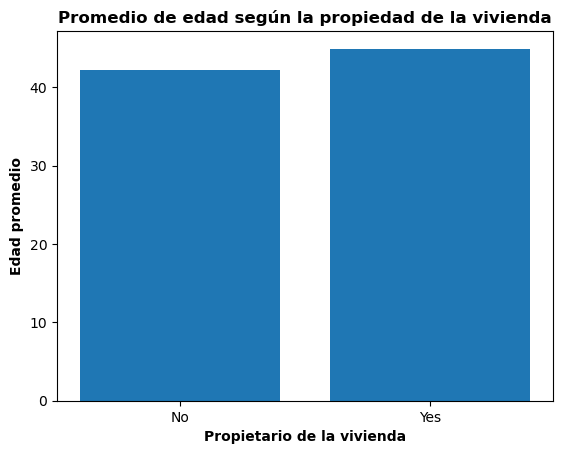

In [135]:
age_mean = data.groupby('Home Owner')['Age'].mean()

# Crear el gráfico de barras apiladas
plt.bar(age_mean.index, age_mean.values, label='Promedio de edad')
plt.xlabel('Propietario de la vivienda', weight = 'bold')
plt.ylabel('Edad promedio', weight = 'bold')
plt.title('Promedio de edad según la propiedad de la vivienda', weight = 'bold')
plt.legend().set_visible(False)
plt.show()

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [137]:
X = data.drop('Purchased Bike', axis = 1)
y = data['Purchased Bike']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['ID', 'Income', 'Children', 'Cars', 'Age']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Commute Distance', 'Region',
                        'Con_hijos', 'Con_vehiculo']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
classifier = DecisionTreeClassifier()
classifier.fit(X_train_processed, y_train)
y_pred = classifier.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.7424242424242424


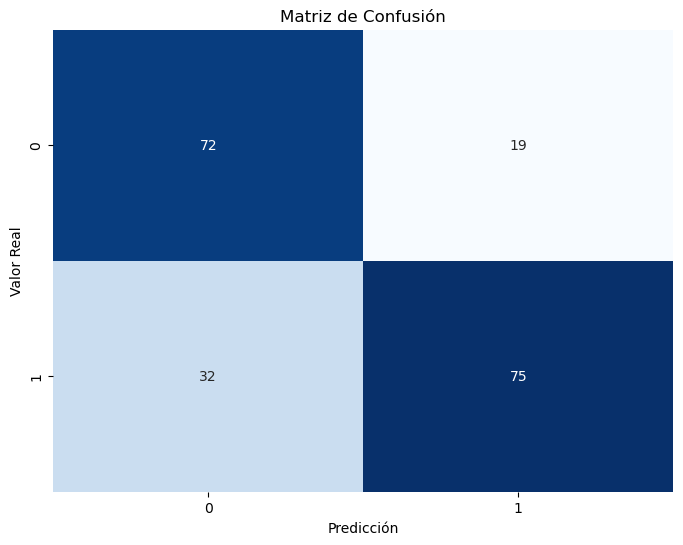

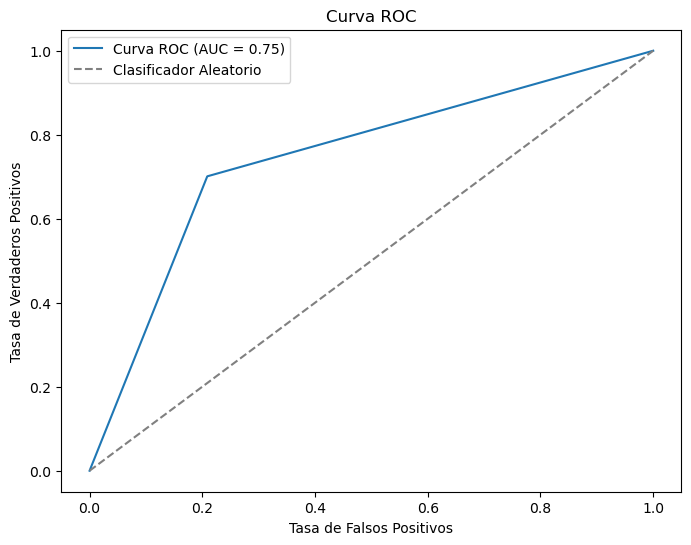

In [138]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, y_pred)

# Crear una visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Calcular la curva ROC y el área bajo la curva (AUC)
probs = classifier.predict_proba(X_test_processed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

# Crear una visualización de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()